# Предсказание marvel vs starwars с использованием Pytorch
Работа в kaggle: https://www.kaggle.com/code/kortana/classification-with-cnn-using-pytorch

В данном ноутбуке были построены две модели классификации с использованием нейронных сестей на основе Pytorch. Для расширения тренировочного набора была произведена аугментация данных с помощью рандомных изменений (сдвиг, поворот, цвет и т.д.). При этом изменений на тестовом наборе не производилось, поскольку качество модели требуется оценить на реальных данных, а не искусственно сгенерированных. После этого была реализована собственная модель со сверточными нейронными слоями, которая показала примерно +-80% точности на тестовой выборке (88 наблюдений). С использование модели ResNet18 с применением предобученных весов было реализован fine tuning, который показал результаты в разы лучше +-95% на тестовом наборе.

In [1]:
from torchvision.datasets import ImageFolder
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import torchvision as tv

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

# Загрузка данных и обработка

In [2]:
transform = transforms.Compose([
    transforms.Resize(size=(200, 200)),
    transforms.ToTensor(),
])
dataset = ImageFolder('/kaggle/input/lego-starwars-marvel/chars', transform=transform)

In [3]:
classes, num = np.unique(dataset.targets, return_counts = True)
print('Сбалансированность классов:', dict(zip(classes, num)))

Сбалансированность классов: {0: 193, 1: 139}


Выборка практически сбалансирована, однако наблюдений в каждом классе очень мало. Расширим с помощью аугментации.

In [4]:
transform = transforms.Compose([
    transforms.Resize(size=(200, 200)),
    v2.RandAugment(num_ops = 4),
    transforms.ToTensor(),
])
dataset_aug = ImageFolder('/kaggle/input/lego-starwars-marvel/chars', transform=transform)

In [5]:
data_train_, data_test = torch.utils.data.random_split(dataset, [0.75, 0.25], generator=torch.Generator().manual_seed(42))
data_train_aug, data_test_aug = torch.utils.data.random_split(dataset_aug, [0.75, 0.25], generator=torch.Generator().manual_seed(42))
data_train = torch.utils.data.ConcatDataset([data_train_, data_train_aug])

In [6]:
print('Количество наблюдений в обучающей выборке до аугментации',len(data_train_))
print('Количество наблюдений в обучающей выборке после аугментации',len(data_train))
print('Количество наблюдений в тестовой выборке до аугментации',len(data_test))
print('Количество наблюдений в тестовой выборке после аугментации',len(data_test))

Количество наблюдений в обучающей выборке до аугментации 249
Количество наблюдений в обучающей выборке после аугментации 498
Количество наблюдений в тестовой выборке до аугментации 83
Количество наблюдений в тестовой выборке после аугментации 83


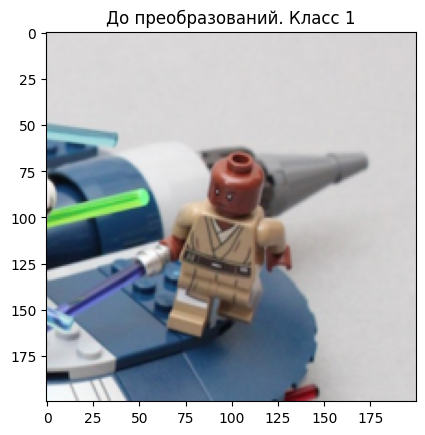

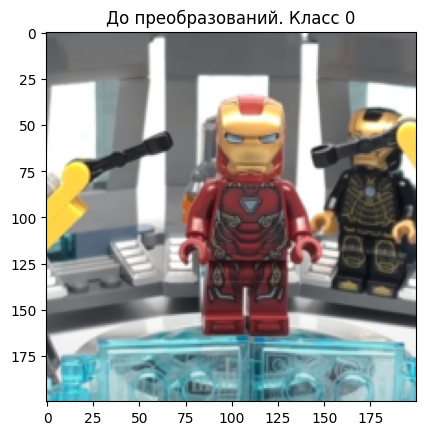

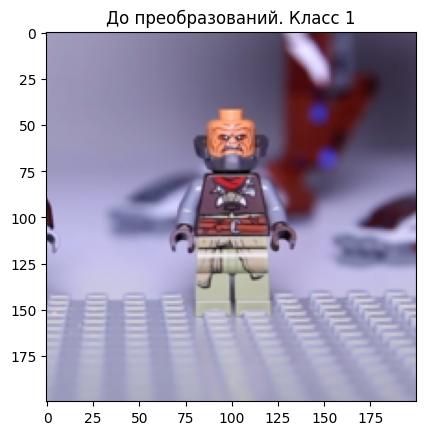

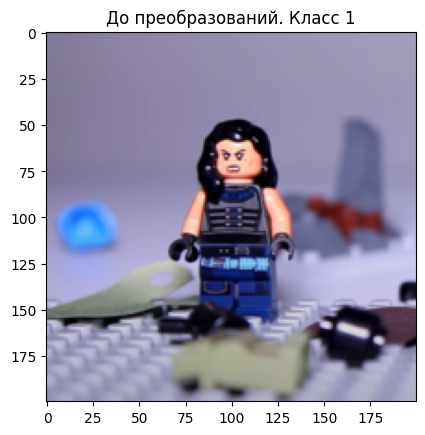

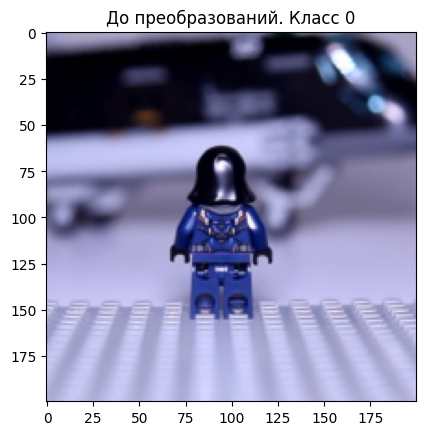

In [7]:
dataiter = iter(data_train_)
for i in range(5):
    img, label = next(dataiter)
    plt.imshow(img.permute(1, 2, 0))
    plt.title('До преобразований. Класс '+str(label))
    plt.show()

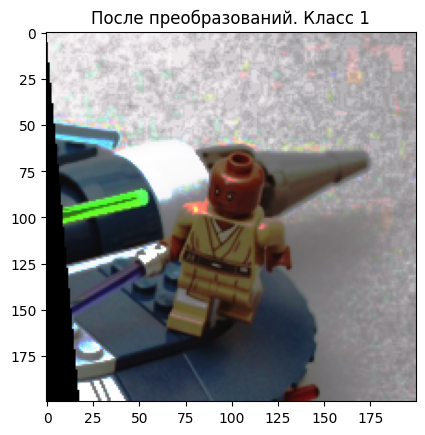

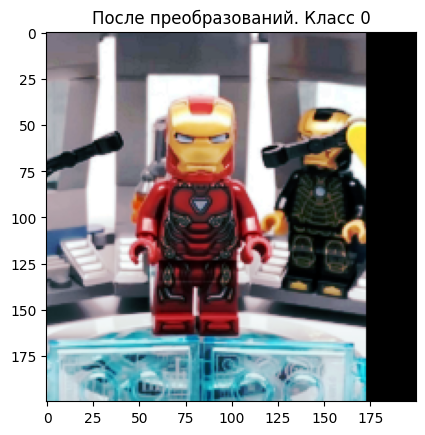

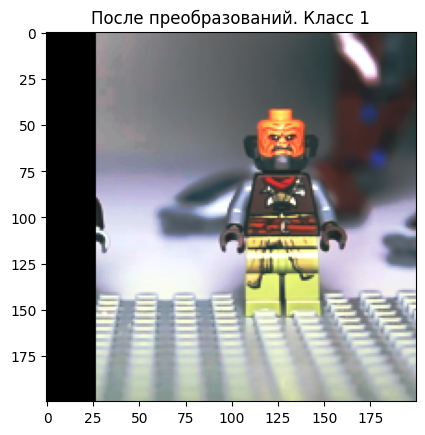

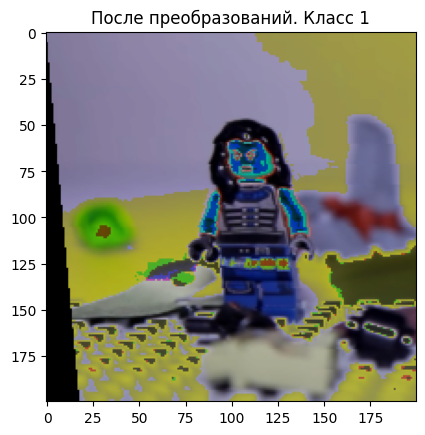

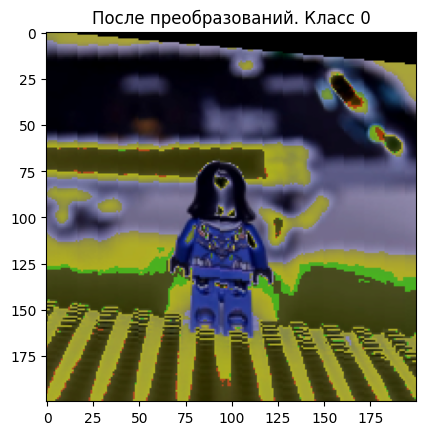

In [8]:
dataiter = iter(data_train_aug)
for i in range(5):
    img, label = next(dataiter)
    plt.imshow(img.permute(1, 2, 0))
    plt.title('После преобразований. Класс '+str(label))
    plt.show()

In [9]:
train_loader = DataLoader(data_train, batch_size = 20, shuffle = True)
test_loader = DataLoader(data_test, batch_size = 20, shuffle = True)

# Построение модели

In [10]:
n_features = 3
n_neurons_1 = 32
n_neurons_2 = 64
n_neurons_3 = 128
n_neurons_4 = 512
n_outputs = 2
losses = []

class Model(nn.Module):
  def __init__(self, n_features, n_neurons_1, n_neurons_2, n_neurons_3, n_neurons_4, n_outputs):
    super().__init__()
    self.fc1 = nn.Conv2d(n_features, n_neurons_1, kernel_size = 3)
    self.fc2 = nn.Conv2d(n_neurons_1, n_neurons_2, kernel_size = 3)
    self.fc3 = nn.Conv2d(n_neurons_2, n_neurons_3, kernel_size = 3)
    self.fc4 = nn.Linear(67712, n_neurons_4)
    self.fc5 = nn.Linear(n_neurons_4, n_outputs)
    self.dropout = nn.Dropout(0.25)
    
  def forward(self, X):
    X = nn.ReLU()(self.fc1(X))
    X = F.max_pool2d(X, 2)
    X = nn.ReLU()(self.fc2(X))
    X = F.max_pool2d(X, 2)
    X = self.dropout(X)
    X = nn.ReLU()(self.fc3(X))
    X = F.max_pool2d(X, 2)
    X = torch.flatten(X, 1)
    X = self.dropout(X)
    X = nn.Softplus()(self.fc4(X))
    y_pred = self.fc5(X)
    return y_pred

model = Model(n_features, n_neurons_1, n_neurons_2, n_neurons_3, n_neurons_4, n_outputs)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Обучение модели

In [11]:
def train(model, epoch):
    train_losses = []
    test_losses = []

    for i in range(epoch):
        model.train()
        losses_epoch_train = []
        losses_epoch_test = []
        y_pred_test = []
        y_true_test = []
        for x_example, y_example in train_loader:
            y_pred = model(x_example)

            loss = criterion(y_pred, y_example)
            losses_epoch_train.append(loss.item())
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        for x_example, y_example in test_loader:
            y_pred = model(x_example)

            loss = criterion(y_pred, y_example)
            losses_epoch_test.append(loss.item())

            y_pred_test.extend(y_pred)
            y_true_test.extend(list(y_example))

        train_losses.append(np.mean(losses_epoch_train))
        test_losses.append(np.mean(losses_epoch_test))
        y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
        y_true_test = list(map(lambda x: x.item(), torch.stack(y_true_test).reshape(-1,1)))
        print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
        print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))
    return model, train_losses, test_losses, y_true_test, y_pred_test

In [12]:
model, train_losses, test_losses, y_true_test, y_pred_test = train(model, 20)

epoch 0: train_loss = 0.71482439, test_loss = 0.65139029
Точность на тестовой выборке: 0.6144578313253012
epoch 1: train_loss = 0.67998378, test_loss = 0.66309069
Точность на тестовой выборке: 0.6144578313253012
epoch 2: train_loss = 0.66576654, test_loss = 0.63207068
Точность на тестовой выборке: 0.6385542168674698
epoch 3: train_loss = 0.64760224, test_loss = 0.63422629
Точность на тестовой выборке: 0.6506024096385542
epoch 4: train_loss = 0.60346396, test_loss = 0.54336024
Точность на тестовой выборке: 0.6987951807228916
epoch 5: train_loss = 0.57032295, test_loss = 0.45228159
Точность на тестовой выборке: 0.6987951807228916
epoch 6: train_loss = 0.56517144, test_loss = 0.54203600
Точность на тестовой выборке: 0.7469879518072289
epoch 7: train_loss = 0.54131401, test_loss = 0.45163735
Точность на тестовой выборке: 0.7108433734939759
epoch 8: train_loss = 0.50264049, test_loss = 0.47933630
Точность на тестовой выборке: 0.7590361445783133
epoch 9: train_loss = 0.49917673, test_loss = 

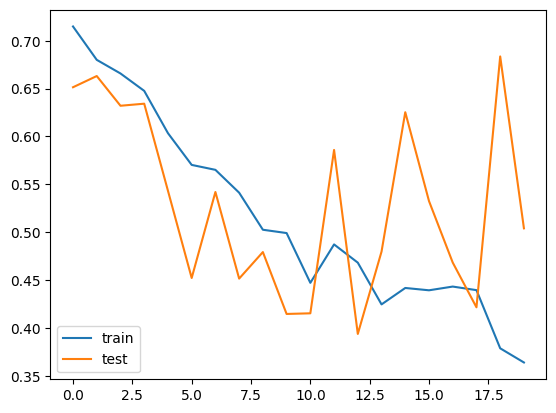

In [13]:
plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.show()

# Оценка на тестовой выборке

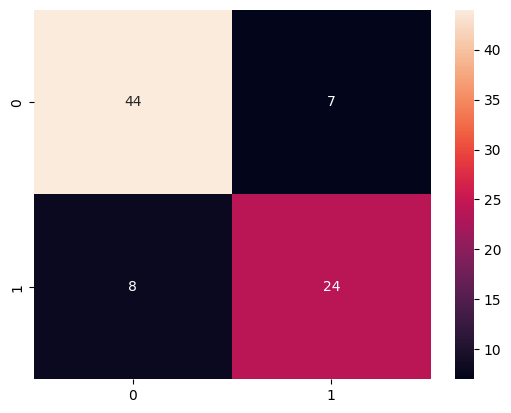

In [14]:
cf_matrix = confusion_matrix(y_true_test, y_pred_test)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [15]:
def look_wrong(model):
    k = 0
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
        y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
        y_true = y_example.numpy()
        for i in range(len(y_pred)):
            if y_true[i]!=y_pred[i]:
                plt.imshow(x_example[i].permute(1, 2, 0))
                plt.title('Реальный класс: '+str(y_true[i]))
                plt.show()
                k+=1
                if k==5:
                    break
        if k==5:
            break

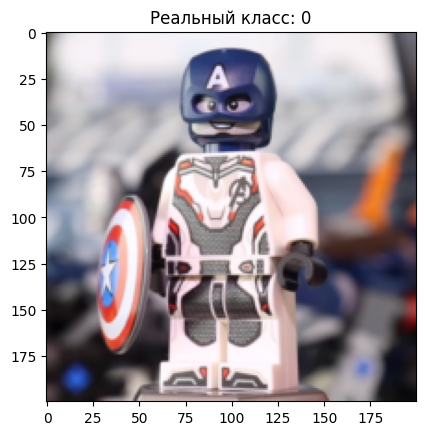

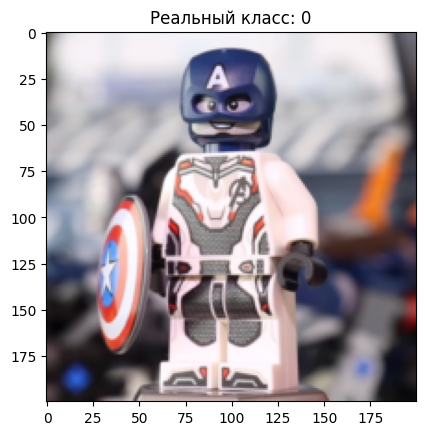

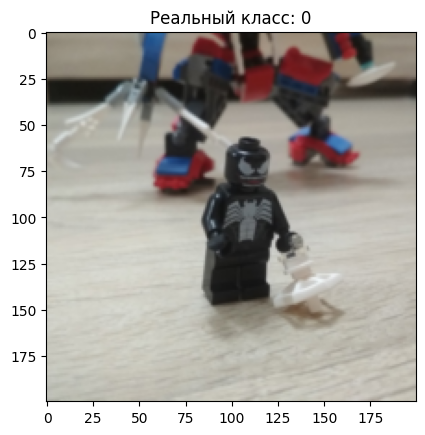

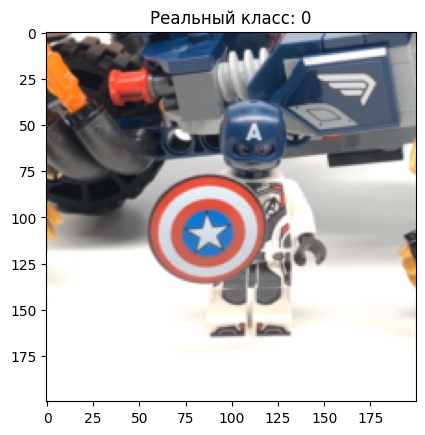

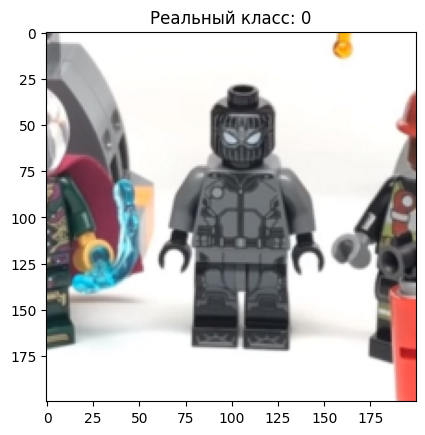

In [16]:
#посмотрим на каких примерах мы ошибаемся
look_wrong(model)

In [17]:
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85        51
           1       0.77      0.75      0.76        32

    accuracy                           0.82        83
   macro avg       0.81      0.81      0.81        83
weighted avg       0.82      0.82      0.82        83



# ResNet18

In [18]:
from torchvision.models import resnet18, ResNet18_Weights
model = nn.Sequential()

model.add_module('resnet', resnet18(weights  = ResNet18_Weights.DEFAULT))

model.add_module('relu_1', nn.ReLU())
model.add_module('fc_1', nn.Linear(1000, 512))
model.add_module('relu_2', nn.ReLU())
model.add_module('fc_2', nn.Linear(512, 2))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [20]:
model, train_losses, test_losses, y_true_test, y_pred_test = train(model, 2)

epoch 0: train_loss = 0.40343077, test_loss = 0.18902883
Точность на тестовой выборке: 0.9156626506024096
epoch 1: train_loss = 0.11535739, test_loss = 0.04885011
Точность на тестовой выборке: 0.9879518072289156


# Оценка ResNet на тестовой выборке 

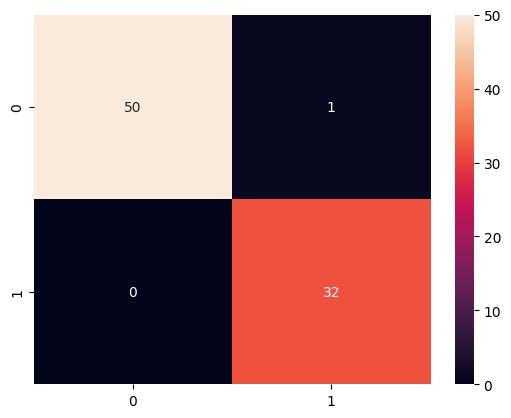

In [21]:
cf_matrix = confusion_matrix(y_true_test, y_pred_test)
ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

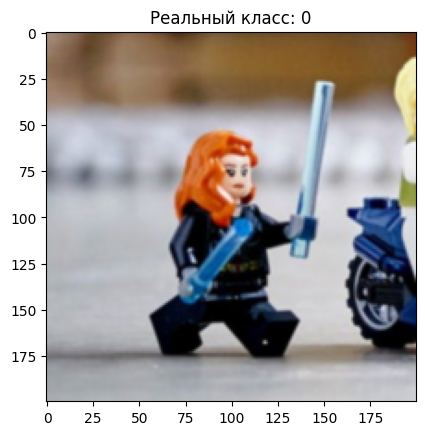

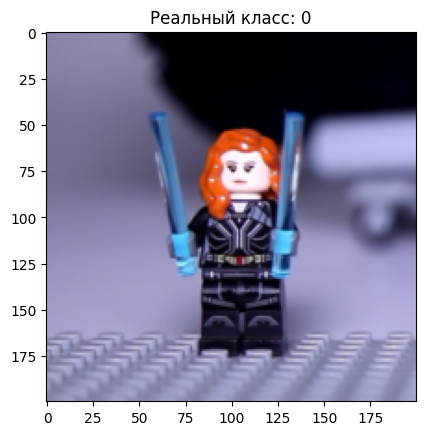

In [22]:
#посмотрим на каких примерах мы ошибаемся
look_wrong(model)

In [23]:
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        51
           1       0.97      1.00      0.98        32

    accuracy                           0.99        83
   macro avg       0.98      0.99      0.99        83
weighted avg       0.99      0.99      0.99        83



Видим прирост качества на ResNet в сравнении с собственной построенной моделью.